# Demo:  CNN Classifier for CIFAR10

In this demo, you will learn to:

* Load the classic CIFAR10 dataset from torch vision library and visualize the images
* Train and test a simple CNN classifier for the dataset
* Enhance the classifiers with batch normalization, dropout and data augmentation and evaluate the relative performance gains.


The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a collection of 60,000 color, `32x32`-pixel images in ten classes. Classes include common objects such as airplanes, automobiles, birds, cats and so on. There are 50,000 train and 10,000 test images. PyTorch can automatically download the dataset from `torchvision`. Note that it will take some time to downloading the dataset for the first time. But, the download will be saved in cache and would not be needed to download again. 

State of the art results are achieved using very large Convolutional Neural networks. Model performance is reported in this [classification accuracy table](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), with state-of-the-art results at 96.5% with human performance on the problem at 94%.  In this demo, we will use a very basic CNN.  With suitable enhancements we can performance ~78%.

Most of the code and the description in this demo is taken from `cifar10_cnn.py` available at [keras-team Github page](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) as well as from the tutorial page by [Jason Brownlee](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/).  Also, thanks to [Phil Schniter](http://www2.ece.ohio-state.edu/~schniter/) for helping adjust some parameters.


## Loading Basic Packages

We first load some basic packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# 4 models:
# 1st mdoel : use_bn = False, use_dropout = False, apply_dataaug = False
# 2nd mdoel : use_bn = True, use_dropout = False, apply_dataaug = False
# rrd mdoel : use_bn = True, use_dropout = True, apply_dataaug = False
# 4th mdoel : use_bn = True, use_dropout = True, apply_dataaug = True


use_bn = True  # or False 
use_dropout = False # or False
apply_dataaug = False # or False

In [4]:
# transforms
if apply_dataaug:
    transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(p=0.5),
         transforms.ToTensor()])
else:
    transform = transforms.Compose(
        [transforms.ToTensor()])

In [5]:
# datasets
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                        shuffle=True, num_workers=4)


testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False, num_workers=4)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


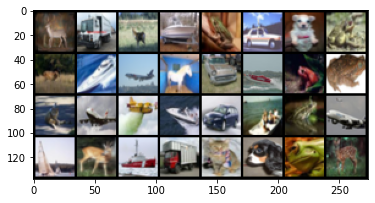

In [8]:
# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))

In [9]:
print(torch.cuda.device_count())

1


The pixel values are in the range of 0 to 1 for each of the red, green and blue channels.

It is good practice to work with normalized data. Because the input values are well understood, if the range is not btween 0 and 1 then we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation.  Note, the data may be loaded as integers, so we must cast it to floating point values if we perform the division.

### Testing Different Classifiers

We now define the network architecture.  The Net class has two arguments:

* `use_bn`:  Adds BatchNormalization
* `use_dropout`:  Adds Dropout layers

By setting the parameters, we can experiment with different model features and compare their performance.  The model has two convolutional layers + two FC layers.  Dropout, if added, is done on the FC layers.

In [10]:
class Net(nn.Module):
    def __init__(self, use_bn, use_dropout):
        super(Net, self).__init__()
        self.num_classes = 10      
        

    def forward(self, x):
        return x

net = Net(use_bn, use_dropout)
net = net.cuda()
print(net)

Net()


In [11]:
# We’ll define the same optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.0001)

ValueError: ignored

In [ ]:
def test_acc(net):
    class_preds = []
    class_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            output = net(images)
            _, class_preds_batch = torch.max(output, 1)

            class_preds.append(class_preds_batch)
            class_labels.append(labels)

    test_preds = torch.cat(class_preds)
    class_labels = torch.cat(class_labels)
    acc = np.mean(test_preds.cpu().numpy()==class_labels.cpu().numpy())
    return acc

In [ ]:
train_class_preds = []
train_class_labels = []

tr_acc_list = []
te_acc_list = []
num_epochs = 3
for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    epoch_running_loss = 0.0
    num_steps = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, class_preds_batch = torch.max(outputs, 1)
        train_class_preds.append(class_preds_batch)
        train_class_labels.append(labels)

        epoch_running_loss += loss.item()
        num_steps += 1
    train_epoch_preds = torch.cat(train_class_preds)
    train_epoch_labels = torch.cat(train_class_labels)
    epoch_tr_acc = np.mean(train_epoch_preds.cpu().numpy()==train_epoch_labels.cpu().numpy())
    tr_acc_list.append(epoch_tr_acc)
    te_acc_list.append(test_acc(net))
    batch_size = inputs.shape[0]
    epoch_average_loss = epoch_running_loss / (num_steps * batch_size)
    if epoch % 20 == 0:
        print("Average training loss per sample for epoch ", epoch +1, " is ", epoch_average_loss)
        print("Training acc of epoch ", epoch + 1, " is ", epoch_tr_acc)
        print("Test acc of epoch ", epoch + 1, " is ", te_acc_list[-1])
print('Finished Training')

tr_acc_npy = np.array(tr_acc_list)
te_acc_npy = np.array(te_acc_list)
np.save('tr_acc_bn_'+str(use_bn)+'_do_'+str(use_dropout)+'_use_da_'+str(apply_dataaug)+'.npy', tr_acc_npy) 
np.save('te_acc_bn_'+str(use_bn)+'_do_'+str(use_dropout)+'_use_da_'+str(apply_dataaug)+'.npy', te_acc_npy)

Average training loss per sample for epoch  1  is  0.07574975654668749
Training acc of epoch  1  is  0.57202
Test acc of epoch  1  is  0.6306
Finished Training


We now plot the results.  You should approximately get

* `baseline`
* `bn`
* `bn+dropout`
* `bn+dropout+augmentation`

So batch normalization and dropout help, but augmentation is not necessary in this case.  Note that if any model gets training accuracies of ~100% it means overfitting.

In [ ]:
# Plot the training and test accuracies vs epoch numbers for the above four models using matplotlib.
simple_tr = np.load('tr_acc_bn_True_do_True_use_da_True.npy') 
print(simple_tr)
simple_te = np.load('te_acc_bn_True_do_True_use_da_True.npy') 
print(simple_te)

[0.48772    0.53302    0.55941333]
[0.5602 0.6006 0.641 ]
